In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Helper functions from Assignment 2

In [2]:


def zero_padding(image, k):
    p = int((k-1)/2)
    padded_image = np.zeros([2*p + image.shape[0], 2*p + image.shape[1], image.shape[2]])
    padded_image[p:-p, p:-p, :] = image
    
    return padded_image 

def scale_minMax(image):
    mini,maxi = np.min(image),np.max(image)
    return (image - mini)/(maxi-mini)

def convolve2d(image,kernel):
    k = kernel.shape[0] # Considering kernel is NxN (filter) matrix
    kernel = np.flipud(np.fliplr(kernel)) #flip 180, equivalent to np.flip(np.flip(kernel,axis=1),axis=-1)
    image = scale_minMax(image)
    
    if len(image.shape) != 3:
        image = image.reshape(image.shape[0],image.shape[1],1)
        
    padded_image = zero_padding(image, k) 
    output = np.zeros_like(image)
    
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            for dim in range(image.shape[2]):
                output[row,col,dim] = np.sum(kernel * padded_image[row: row+k, col: col+k,dim])
                
    if image.shape[2] == 1:
        return output.reshape(image.shape[0],image.shape[1])
    else:
        return output

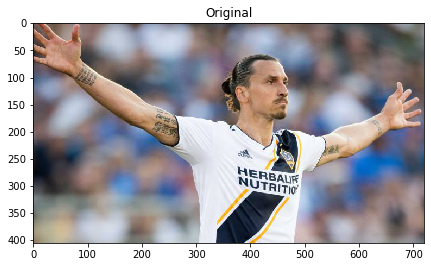

In [3]:

def mse(imageA, imageB):
    err = np.sum((imageA - imageB) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def show_differences(img,noise,smooth):
    plt.figure(figsize=[20,15])
    plt.subplot(331)
    plt.imshow(img,cmap='gray')
    plt.title("Original")
    plt.subplot(332)
    plt.imshow(noise,cmap='gray')
    plt.title("Original + noise")
    plt.subplot(333)
    plt.imshow(smooth,cmap='gray')
    plt.title("After Smoothing")

    plt.subplot(334)
    plt.hist(img.ravel(),256,[0,1])
    plt.title("Original Histogram")
    plt.subplot(335)
    plt.hist(noise.ravel(),256,[0,1])
    plt.title("Original + noise Histogram")
    plt.subplot(336)
    plt.hist(smooth.ravel(),256,[0,1])
    plt.title("After Smoothing Histogram")
    plt.subplot(338)
    
    kwargs = dict(histtype='barstacked',alpha=0.4, density=True, bins=256)
    plt.hist(img.ravel(),color='blue',**kwargs)
    plt.hist(noise.ravel(),color='red', **kwargs)
    plt.hist(smooth.ravel(),color='lime', **kwargs)
    plt.legend(['Original','Original + noise','After Smoothing'])
    plt.title("Differences")
    plt.show()
    print(f'MSE of the original and [original + noise]: \t{mse(img,noise)}')
    print(f'MSE of the [original + noise] and smooth: \t{mse(noise,smooth)}')
    print(f'MSE of the original and smooth: \t{mse(img,smooth)}')
    
def plot_image(img,title='image'):
    plt.figure(figsize=[7,7])
    if len(img.shape) != 3:
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title)
    

image = plt.imread('./images/zlatan.jpg')
#image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
plot_image(image,'Original')

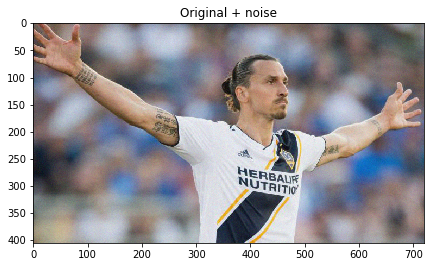

In [4]:
def guassian_noise(img,mean=0,sigma=5):
    gauss = np.random.normal(mean,sigma,img.shape)
    gauss = gauss.reshape(img.shape)
    noisey_image = img + gauss
    return noisey_image

noisey_image = guassian_noise(image)
noisey_image = scale_minMax(noisey_image)
plot_image(noisey_image,'Original + noise')

# Using Average filtering (Box Kernel)

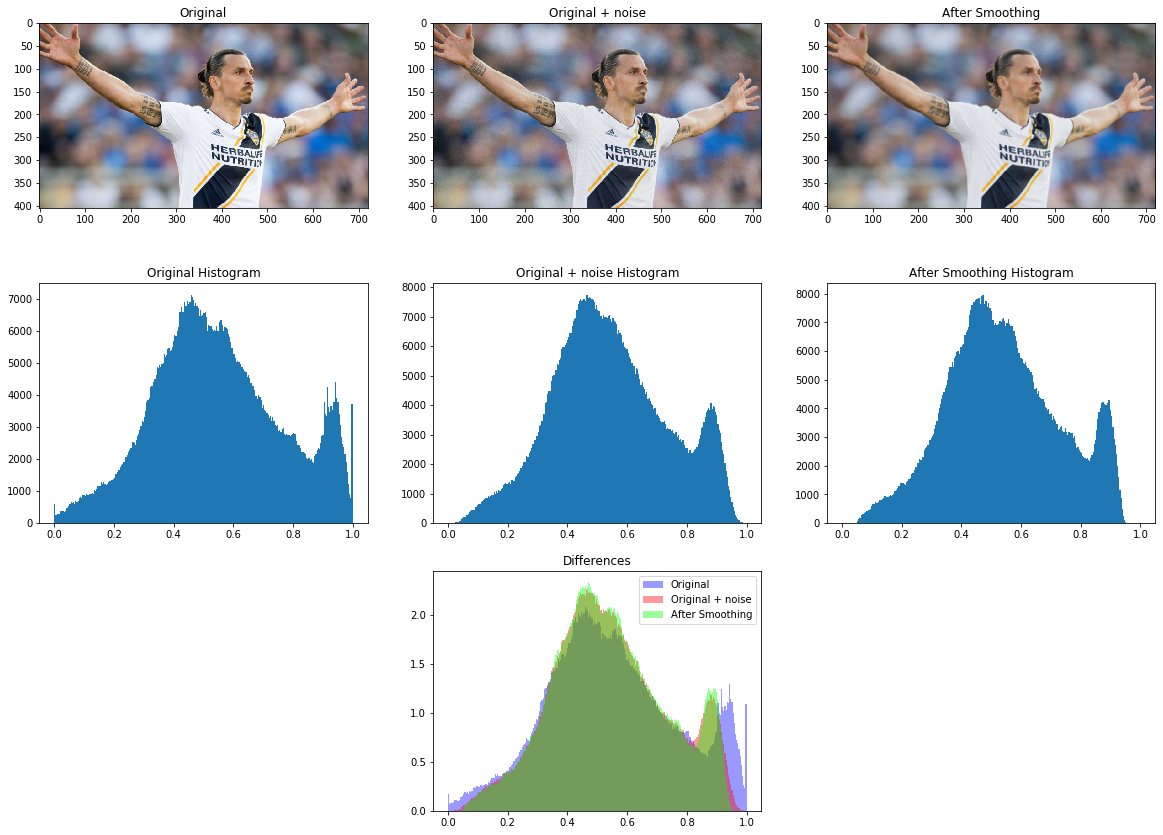

MSE of the original and [original + noise]: 	0.0029009123511092153
MSE of the [original + noise] and smooth: 	0.00280081334373281
MSE of the original and smooth: 	0.004846915764988288


In [5]:
k = 1 
kernel_dim = 2*k+1 # k_dim = 3
kernel = np.ones([kernel_dim,kernel_dim])/(kernel_dim)**2
smooth = convolve2d(image=noisey_image,kernel=kernel)

norm_image = scale_minMax(image)
show_differences(norm_image,noisey_image,smooth)


# Using Gaussian Blur kernel

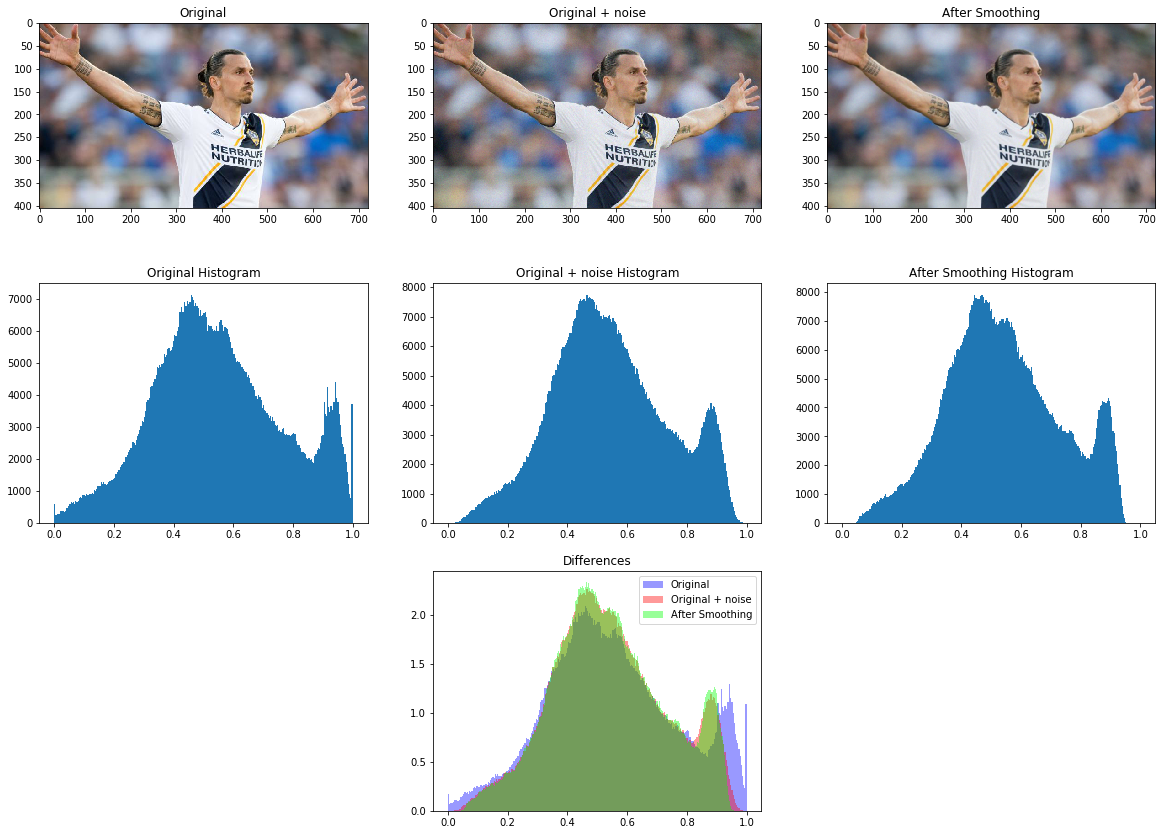

MSE of the original and [original + noise]: 	0.0029009123511092153
MSE of the [original + noise] and smooth: 	0.001775024399091215
MSE of the original and smooth: 	0.0038980387733576647


In [6]:
gauss_kernel = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
smooth = convolve2d(image=noisey_image,kernel=gauss_kernel)

norm_image = scale_minMax(image)
show_differences(norm_image,noisey_image,smooth)

# Image Rotation

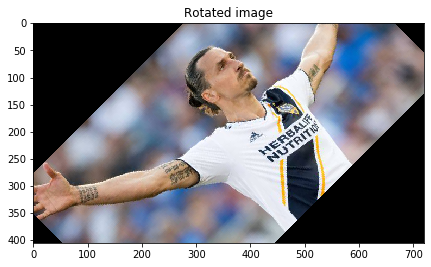

In [14]:
#counter clockwise rotation
def getRotMat(angle):
    radian = np.deg2rad(angle)
    c, s = np.cos(radian), np.sin(radian)
    return np.array([[c, -s, 0],
                     [s, c, 0],
                     [0, 0, 1]])

def get_inverse_traformation_mat(mat,x0,y0):
    translate1 = np.array([[1, 0, -x0],
                           [0, 1, -y0],
                           [0, 0, 1]]) # move to center translation mat
    
    translate2 = np.array([[1, 0, x0],
                           [0, 1, y0],
                           [0, 0, 1]]) # align to x,y translation mat
    
    return np.linalg.inv(translate2 @ mat @ translate1) # @ dot

def rotate(image,angle):
    result = np.zeros_like(image)
    centerX = int(image.shape[0]) / 2
    centerY = int(image.shape[1])/ 2
    rot_mat = getRotMat(angle)
    trans_matrix = get_inverse_traformation_mat(rot_mat,centerX,centerY)
    
    #calculate the source pixels value instead of target destination 
    nh,nw,ch = result.shape
    for chan in range(ch):
        for x, y in np.ndindex(nh,nw):
            x_orig, y_orig, _ = np.round(trans_matrix @ [x, y, 1]).astype('int64')

            if 0 < x_orig < image.shape[0] and 0 < y_orig < image.shape[1]:
                result[x, y,chan] = image[x_orig, y_orig,chan]
            
    return result

plot_image(rotate(image,45),title='Rotated image')

# Encrypt Images

In [8]:
img_messi = cv2.resize(plt.imread('./images/messi.jpg'), (600,600)).astype('uint8')
img_lenna = (cv2.resize(plt.imread('./images/Lenna.png'), (200,200))*255).astype('uint8')

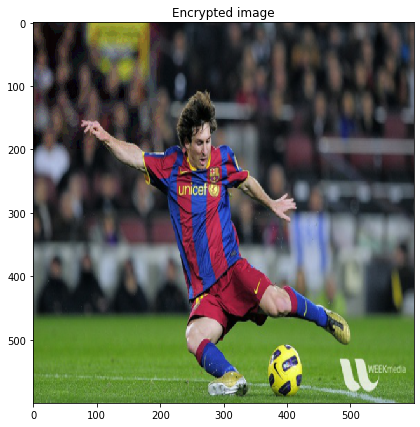

In [9]:
def merge(x1,x2):
    ms = (x1 & 240)
    ls = (x2 & 240) >> 4
    return ms | ls
    
def encrypt_pix(px1,px2):
    r1,g1,b1 = px1
    r2,g2,b2 = px2
    return merge(r1,r2),merge(g1,g2),merge(b1,b2)

def encrypt_image(image1,image2):
    result = np.zeros_like(image1)
    for x in range(image1.shape[0]):
        for y in range(image1.shape[1]):
            if x < image2.shape[0] and y < image2.shape[1]:
                result[x,y] = encrypt_pix(image1[x,y],image2[x,y])
            else:
                result[x,y] = image1[x,y]
    return result
    
encrypted = encrypt_image(img_messi,img_lenna)
plot_image(encrypted,title='Encrypted image')      

# Decrypt Image

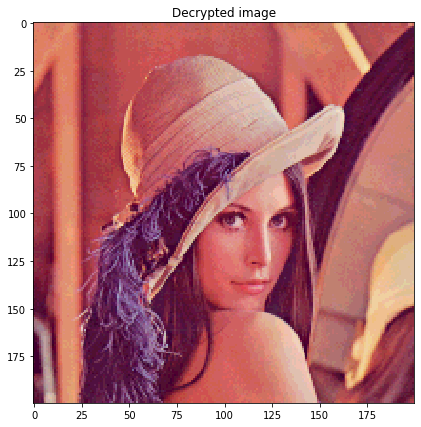

In [10]:
def extract(px):
    return (px & 15) << 4

def decrypt_pix(px):
    r,g,b = px
    return extract(r),extract(g),extract(b)

def decrypt_image(encrypt_img,dim):
    result = np.zeros(dim).astype('uint8')
    for x in range(dim[0]):
        for y in range(dim[1]):
            result[x,y] = decrypt_pix(encrypt_img[x,y])
    return result

res = decrypt_image(encrypted,img_lenna.shape)
plot_image(decrypt_image(encrypted,img_lenna.shape) ,title='Decrypted image')        

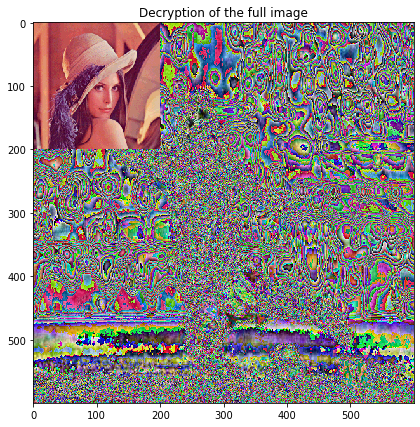

In [11]:
plot_image(decrypt_image(encrypted,encrypted.shape),"Decryption of the full image")

Object `astype` not found.


In [ ]:
np.round(trans_matrix @ [x, y, 1]).astype

In [6]:
h2 = np.array([[0,-2,-1],
                   [2,0,-2],
                   [1,2,0]])
h1 = np.array([[0,0,0],
               [1,0,0],
               [0,0,0]])
np.flipud(np.fliplr(h1))

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 0]])

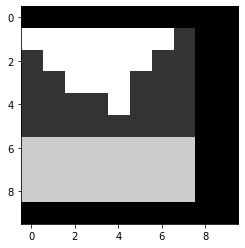

In [28]:
import scipy.signal



f = np.array(
[
[200,200,200,200,200,200,200,40],
[40,200,200,200,200,200,40,40],
[40,40,200,200,200,40,40,40],
[40,40,40,40,200,40,40,40],
[40,40,40,40,40,40,40,40],
[160,160,160,160,160,160,160,160],
[160,160,160,160,160,160,160,160],
[160,160,160,160,160,160,160,160]
])
h2  = np.array([[0,-2,-1],
                   [2,0,-2],
                   [1,2,0]])/5 
plt.imshow(f,cmap='gray')
image_kernel_sc = scipy.signal.convolve2d(f, h1,mode = 'full')
plt.imshow(image_kernel_sc,cmap='gray')

In [27]:
print(image_kernel_sc)

[[  0   0   0   0   0   0   0   0   0   0]
 [200 200 200 200 200 200 200  40   0   0]
 [ 40 200 200 200 200 200  40  40   0   0]
 [ 40  40 200 200 200  40  40  40   0   0]
 [ 40  40  40  40 200  40  40  40   0   0]
 [ 40  40  40  40  40  40  40  40   0   0]
 [160 160 160 160 160 160 160 160   0   0]
 [160 160 160 160 160 160 160 160   0   0]
 [160 160 160 160 160 160 160 160   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


In [23]:
scipy.signal.convolve2d?

In [47]:
afeka = plt.imread('./images/Capture.PNG')
afeka = cv2.cvtColor(afeka,cv2.COLOR_RGB2GRAY)
kernel  = np.array([[1,2,1],
                    [0,0,0],
                    [-1,-2,-1]])
image_kernel_sc = scipy.signal.convolve2d(afeka, kernel)

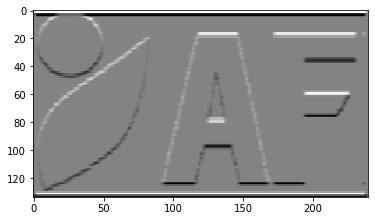

In [48]:
plt.imshow(image_kernel_sc,cmap='gray')